# ADDA for ST

Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
from math import ceil
import glob
import os
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad

import scipy.stats as ss
from scipy.sparse import csr_matrix
import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch.nn import functional as F
from torch import nn

import datetime
import json

# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
results_folder = os.path.join('results', script_start_time)
model_folder = os.path.join('model_cell_dart', script_start_time)

model_folder = os.path.join('model_cell_dart', 'TESTING')

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

if not os.path.isdir(results_folder):
    os.makedirs(results_folder)

In [4]:
num_markers = 20
n_mix = 8
n_spots = 20000

sample_id_n = '151673'

batch_size = 512
num_workers = 4
initial_train_epochs = 100

early_stop_crit = 100
min_epochs = initial_train_epochs


early_stop_crit_adv = 10
min_epochs_adv = 10

# Define model components

In [5]:
class MLPEncoder(nn.Module):
    def __init__(self, inp_dim, emb_dim):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(inp_dim, 1024), 
            nn.BatchNorm1d(1024, eps=0.001, momentum=0.99), 
            nn.ELU(),

            nn.Linear(1024, emb_dim), 
            nn.BatchNorm1d(emb_dim, eps=0.001, momentum=0.99), 
            nn.ELU()
        )

    def forward(self, x):
        return self.encoder(x)

In [6]:
class Classifier(nn.Module):
    def __init__(self, emb_dim, ncls_source):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(emb_dim, ncls_source), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.head(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(emb_dim, 32), 
            nn.BatchNorm1d(32, eps=0.001, momentum=0.99), 
            nn.ELU(), 
            
            nn.Dropout(0.5),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.head(x)

In [8]:
def set_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [9]:
class ADDAST(nn.Module):
    def __init__(self, inp_dim, emb_dim, ncls_source):
        super().__init__()

        self.source_encoder = MLPEncoder(inp_dim, emb_dim)
        self.target_encoder = MLPEncoder(inp_dim, emb_dim)
        self.clf = Classifier(emb_dim, ncls_source)
        self.dis = Discriminator(emb_dim)

        self.is_encoder_source = True

    def forward(self, x):
        if self.is_encoder_source:
            x = self.source_encoder(x)
        else:
            x = self.target_encoder(x)

        x = self.clf(x)

        return x

    def pretraining(self):
        self.is_encoder_source = True
        set_requires_grad(self.source_encoder, True)
        set_requires_grad(self.clf, True)

    def advtraining(self, train_dis=True):
        set_requires_grad(self.source_encoder, False)

        if train_dis:
            self.train_discriminator()
        else:
            self.train_target_encoder()

    def target_inference(self):
        self.is_encoder_source = False

    def train_discriminator(self):
        set_requires_grad(self.target_encoder, False)
        set_requires_grad(self.dis, True)

    def train_target_encoder(self):
        set_requires_grad(self.target_encoder, True)
        set_requires_grad(self.dis, False)

    def set_encoder(self, encoder="source"):
        if encoder == "source":
            self.is_encoder_source = True
        elif encoder == 'target':
            self.is_encoder_source = False
        else:
            current_encoder_str = '\'source\'' if self.is_encoder_source else '\'target\''
            warnings.warn(
                f"encoder parameter should be 'source' or 'target', got {encoder}; encoder is currently {current_encoder_str}",
                RuntimeWarning
            )


In [10]:
class SpotDataset(torch.utils.data.Dataset):
    """Dataset for cell spots. Returns a spot with GEx data, and optionally cell type distribution"""
    def __init__(self, X, Y=None):
        """
        Args:
            X (array_like of rank 2): An (n_spots, n_genes) array of normalized log gene expression values.
            Y (array_like of rank 2, optional): An (n_spots, n_cell_types) array of cell type distribution.
        """
        super().__init__()

        self.X = torch.as_tensor(X).float()
        assert self.X.dim() == 2, f"X should be rank 2, got {self.X.dim()}"

        if Y is None:
            self.Y = Y
        else:
            self.Y = torch.as_tensor(Y).float()
            assert self.Y.dim() == 2, f"Y should be rank 2, got {self.Y.dim()}"
            assert len(self.X) == len(self.Y), "X and Y unequal lengths"

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.Y is None:
            return self.X[idx]
        else:
            return self.X[idx], self.Y[idx]


# Prepare Data
## Data load
### Load SpatialLIBD Data

In [11]:
spatialLIBD_dir = './data/spatialLIBD'

sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

adata_dir = os.path.join(spatialLIBD_dir, 'adata')

adata_spatialLIBD_d = {}

for name in glob.glob(os.path.join(adata_dir, 'adata_spatialLIBD-*.h5ad')):
    sample_id = name.partition("-")[2].rpartition(".")[0]
    # print(sample_id)
    adata_spatialLIBD_d[sample_id] = sc.read_h5ad(name)

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
h5py                        3.6.0
igraph                      0.9.10
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
joblib                      1.1.0
jupyter_server              1.18.1
kiwisolver                  1.4.2
leidenalg                   0.8.10
llvmlite                    0.38.0
matplotlib                  3.5.1
matplo

### Load Single Cell Data

In [12]:
adata_sc_dlpfc = sc.read_h5ad('./data/sc_dlpfc/adata_sc_dlpfc.h5ad')
sc.pp.normalize_total(adata_sc_dlpfc, inplace=True, target_sum=1e6)
adata_sc_dlpfc.var_names_make_unique()

normalizing counts per cell
    finished (0:00:00)


## Find Marker Genes

In [13]:
#Preprocessing
# adata_sc_dlpfc.var['mt'] = adata_sc_dlpfc.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata_sc_dlpfc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# sc.pp.normalize_total(adata_sc_dlpfc)

# #PCA and clustering : Known markers with 'cell_subclass'
# sc.tl.pca(adata_sc_dlpfc, svd_solver='arpack')
# sc.pp.neighbors(adata_sc_dlpfc, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_sc_dlpfc)
# sc.tl.leiden(adata_sc_dlpfc, resolution = 0.5)
# sc.pl.umap(adata_sc_dlpfc, color=['leiden','cell_subclass'])

In [14]:
# sc.tl.rank_genes_groups(adata_sc_dlpfc, 'cell_subclass', method='wilcoxon')
# # sc.pl.rank_genes_groups(adata_sc_dlpfc, n_genes=20, sharey=False)
# genelists = adata_sc_dlpfc.uns['rank_genes_groups']['names']
# df_genelists = pd.DataFrame.from_records(genelists)
# df_genelists.to_pickle('data/sc_dlpfc/df_genelists.pkl')

In [15]:
df_genelists = pd.read_pickle('data/sc_dlpfc/df_genelists.pkl')
res_genes = []
for column in df_genelists.head(num_markers):
    res_genes.extend(df_genelists.head(num_markers)[column].tolist())
res_genes_ = list(set(res_genes))

# with open('data/res_genes_.json', 'w') as f:
#     json.dump(res_genes_, f)

In [16]:
# with open('data/res_genes_.json') as f:
#     res_genes_ = json.load(f)

### Select same gene features 

In [17]:
adata_spatialLIBD = ad.concat(
    adata_spatialLIBD_d.values(), 
    label='sample_id', 
    keys=adata_spatialLIBD_d.keys()
)
adata_spatialLIBD.obs_names_make_unique()
sc.pp.normalize_total(adata_spatialLIBD, inplace=True, target_sum=1e6)

normalizing counts per cell


/home/wma/miniconda3/envs/agreda2/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)


In [18]:
adata_spatialLIBD.var_names_make_unique()
inter_genes = [val for val in res_genes_ if val in adata_spatialLIBD.var.index]
print('Selected Feature Gene number', len(inter_genes))
adata_sc_dlpfc = adata_sc_dlpfc[:, inter_genes]

adata_spatialLIBD = adata_spatialLIBD[:, inter_genes]


Selected Feature Gene number 362


## Format Data

In [19]:
mat_sc = adata_sc_dlpfc.X.todense()
mat_sp_train = adata_spatialLIBD[adata_spatialLIBD.obs.sample_id == sample_id_n].X.todense()
# mat_sp_train = adata_spatialLIBD.X.todense()
mat_sp_test = adata_spatialLIBD[adata_spatialLIBD.obs.sample_id == sample_id_n].X.todense()

df_sc = adata_sc_dlpfc.obs

lab_sc_sub = df_sc.cell_subclass
sc_sub_dict = dict(zip(range(len(set(lab_sc_sub))), df_genelists.columns.tolist()))
sc_sub_dict2 = dict((y, x) for x, y in sc_sub_dict.items())
lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
lab_sc_num = np.asarray(lab_sc_num, dtype='int')

### Generate Pseudospots

In [20]:
from sklearn.preprocessing import OneHotEncoder


def random_mix(Xs, ys, nmix=5, n_samples=10000, seed=0):
    # Define empty lists
    Xs_new, ys_new = [], []
    ys_ = OneHotEncoder().fit_transform(ys.reshape(-1, 1)).toarray()

    rstate = np.random.RandomState(seed)
    fraction_all = rstate.rand(n_samples, nmix)
    randindex_all = rstate.randint(len(Xs), size=(n_samples, nmix))

    for i in range(n_samples):
        # fraction: random fraction across the "nmix" number of sampled cells
        fraction = fraction_all[i]
        fraction = fraction / np.sum(fraction)
        fraction = np.reshape(fraction, (nmix, 1))

        # Random selection of the single cell data by the index
        randindex = randindex_all[i]
        ymix = ys_[randindex]
        # Calculate the fraction of cell types in the cell mixture
        yy = np.sum(ymix * fraction, axis=0)
        # Calculate weighted gene expression of the cell mixture
        XX = np.asarray(Xs[randindex]) * fraction
        XX_ = np.sum(XX, axis=0)

        # Add cell type fraction & composite gene expression in the list
        ys_new.append(yy)
        Xs_new.append(XX_)

    Xs_new = np.asarray(Xs_new)
    ys_new = np.asarray(ys_new)

    return Xs_new, ys_new

In [21]:
mat_sc_train, mat_sc_test, lab_sc_num_train, lab_sc_num_test = train_test_split(
    mat_sc, lab_sc_num, test_size=0.2, random_state=225, stratify=lab_sc_num
)

sc_mix_train, lab_mix_train = random_mix(mat_sc_train, lab_sc_num_train, nmix=n_mix, n_samples=n_spots)
sc_mix_test, lab_mix_test = random_mix(mat_sc_test, lab_sc_num_test, nmix=n_mix, n_samples=n_spots // 4)


def log_minmaxscale(arr):
    arrd = len(arr)
    arr = np.log1p(arr)
    return (arr - np.reshape(np.min(arr, axis=1),
                             (arrd, 1))) / np.reshape((np.max(arr, axis=1) - np.min(arr, axis=1)), (arrd, 1))


sc_mix_train_s = log_minmaxscale(sc_mix_train)
sc_mix_test_s = log_minmaxscale(sc_mix_test)

mat_sp_train_s = log_minmaxscale(mat_sp_train)
mat_sp_test_s = log_minmaxscale(mat_sp_test)
mat_sc_s = log_minmaxscale(mat_sc)

In [22]:
source_train_set = SpotDataset(sc_mix_train_s, lab_mix_train)
source_test_set = SpotDataset(sc_mix_test_s, lab_mix_test)

target_train_set = SpotDataset(mat_sp_train_s)
target_test_set = SpotDataset(mat_sp_test_s)

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers, 
    pin_memory=True
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)

dataloader_target_train = torch.utils.data.DataLoader(
    target_train_set, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers, 
    pin_memory=True
)
dataloader_target_test = torch.utils.data.DataLoader(
    target_test_set, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)


# Training: Adversarial domain adaptation for cell fraction estimation

## Define Model

In [23]:
model = ADDAST(
    sc_mix_train_s.shape[1], 
    emb_dim=64, 
    ncls_source=lab_mix_train.shape[1]
)

model.to(device)

ADDAST(
  (source_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (target_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (clf): Classifier(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
      (1): Lo

## Pretrain

In [24]:
pretrain_folder = os.path.join(model_folder, "pretrain")

if not os.path.isdir(pretrain_folder):
    os.makedirs(pretrain_folder)

In [25]:
pre_optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.001, 
    betas=(0.9, 0.999), 
    eps=1e-07
)

criterion = nn.KLDivLoss(reduction="batchmean")

In [26]:
model.pretraining()

In [27]:
def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, (x, y_true) in enumerate(dataloader):

            x = x.to(torch.float32).to(device)
            y_true = y_true.to(torch.float32).to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y_true)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(x))

    # print(len(loss_running), len(mean_weights))
    return np.average(loss_running, weights=mean_weights)

In [28]:
from tqdm.autonotebook import tqdm

# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0

# Train
print("Start pretrain...")
outer = tqdm(total=initial_train_epochs, desc='Epochs', position=0)
inner = tqdm(total=len(dataloader_source_train), desc=f'Batch', position=1)
for epoch in range(initial_train_epochs):

    # check to see if validation loss has plateau'd
    if early_stop_count >= early_stop_crit and epoch > min_epochs:
        print(f'Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch')
        checkpoint = {
            'epoch': epoch,
            'model': model,
            'optimizer': pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(
            checkpoint,
            os.path.join(pretrain_folder, f'checkpt_earlystop_{epoch}.pth')
        )
        break

    early_stop_count += 1

    #Train mode
    model.train()
    loss_running = []
    mean_weights = []

    inner.refresh()  #force print final state
    inner.reset()  #reuse bar
    for _, (x, y_true) in enumerate(dataloader_source_train):
        # lr_history_running.append(scheduler.get_last_lr())

        pre_optimizer.zero_grad()
        x = x.to(torch.float32).to(device)
        y_true = y_true.to(torch.float32).to(device)

        y_pred = model(x)

        loss = criterion(y_pred, y_true)

        loss_running.append(loss.item())

        # we will weight average by batch size later
        mean_weights.append(len(x))

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        loss.backward()
        pre_optimizer.step()
        # Change the learning rate
        # scheduler.step()

        inner.update(1)

    loss_history.append(np.average(loss_running, weights=mean_weights))

    loss_history_running.append(loss_running)

    # Evaluate mode
    model.eval()
    with torch.no_grad():
        curr_loss_val = compute_acc(dataloader_source_train, model)
        loss_history_val.append(curr_loss_val)

    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = {
            'epoch': epoch,
            'model': model,
            'optimizer': pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f'best_model.pth'))
        early_stop_count = 0

    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= initial_train_epochs - 1:
        checkpoint = {
            'epoch': epoch,
            'model': model,
            'optimizer': pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(
            checkpoint, os.path.join(pretrain_folder, f'checkpt{epoch}.pth')
        )

    # Print the results
    outer.update(1)
    print(
        "epoch:", epoch, \
        "train loss:", round(loss_history[-1], 6), \
        "validation loss:", round(loss_history_val[-1], 6), \
        # "next_lr:", scheduler.get_last_lr(),





    )

# Save final model
checkpoint = {
    'epoch': epoch,
    'model': model,
    'optimizer': pre_optimizer,
    # 'scheduler': scheduler,
    # 'scaler': scaler
}
torch.save(checkpoint, os.path.join(pretrain_folder, f'final_model.pth'))

Start pretrain...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch: 0 train loss: 1.192109 validation loss: 0.855626
epoch: 1 train loss: 0.832209 validation loss: 0.699647
epoch: 2 train loss: 0.675084 validation loss: 0.638187
epoch: 3 train loss: 0.607443 validation loss: 0.600825
epoch: 4 train loss: 0.575714 validation loss: 0.679953
epoch: 5 train loss: 0.555039 validation loss: 0.594332
epoch: 6 train loss: 0.539213 validation loss: 0.534002
epoch: 7 train loss: 0.521288 validation loss: 0.584108
epoch: 8 train loss: 0.511462 validation loss: 0.522743
epoch: 9 train loss: 0.497102 validation loss: 0.500698
epoch: 10 train loss: 0.481399 validation loss: 0.542302
epoch: 11 train loss: 0.471477 validation loss: 0.602004
epoch: 12 train loss: 0.461531 validation loss: 0.571391
epoch: 13 train loss: 0.448045 validation loss: 0.587676
epoch: 14 train loss: 0.436272 validation loss: 0.526245
epoch: 15 train loss: 0.4252 validation loss: 0.73097
epoch: 16 train loss: 0.416158 validation loss: 0.531911
epoch: 17 train loss: 0.400962 validation lo

## Adversarial Adaptation

In [29]:
best_checkpoint = torch.load(os.path.join(pretrain_folder, f'final_model.pth'))
model = best_checkpoint['model']
model.to(device)

ADDAST(
  (source_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (target_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (clf): Classifier(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
      (1): Lo

In [30]:
def cycle_iter(iter):
    while True:
        yield from iter


In [31]:
def batch_generator(data, batch_size):
    """Generate batches of data.
    Given a list of numpy data, it iterates over the list and returns batches of the same size
    This
    """
    all_examples_indices = len(data[0])
    while True:
        mini_batch_indices = np.random.choice(all_examples_indices, size=batch_size, replace=False)
        tbr = [k[mini_batch_indices] for k in data]
        yield tbr

In [32]:
S_batches = batch_generator([sc_mix_train_s.copy(), lab_mix_train.copy()], batch_size)
T_batches = batch_generator([mat_sp_train_s.copy(), np.zeros(shape = (len(mat_sp_train_s),2))], batch_size)

In [33]:
source_train_set_eval = SpotDataset(sc_mix_train_s.copy(), lab_mix_train.copy())

target_train_set_eval = SpotDataset(mat_sp_train_s.copy())

dataloader_source_train_eval = torch.utils.data.DataLoader(
    source_train_set_eval, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=False
)

dataloader_target_train_eval = torch.utils.data.DataLoader(
    target_train_set_eval, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=False
)

In [34]:
n_iter = 3000
epochs = 1000
alpha_lr = 5
alpha = 0.6

advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)

criterion_dis = nn.CrossEntropyLoss()

criterion_clf = nn.KLDivLoss(reduction="batchmean")

from itertools import chain

enc_optimizer = torch.optim.Adam(
    chain(model.source_encoder.parameters(), model.dis.parameters(), model.clf.parameters()),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-07
)

dis_optimizer = torch.optim.Adam(
    chain(model.source_encoder.parameters(), model.dis.parameters()),
    lr= alpha_lr * 0.001,
    betas=(0.9, 0.999),
    eps=1e-07
)


In [35]:
def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, (x, y_true) in enumerate(dataloader):

            x = x.to(torch.float32).to(device)
            y_true = y_true.to(torch.float32).to(device)

            y_pred = model(x)

            loss = criterion_clf(y_pred, y_true)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(x))

    # print(len(loss_running), len(mean_weights))
    return np.average(loss_running, weights=mean_weights)

def compute_acc_dis(dataloader_source, dataloader_target, model):
    len_target = len(dataloader_target)
    len_source = len(dataloader_source)




    loss_running = []
    accu_running = []
    mean_weights = []
    model.eval()
    model.source_encoder.eval()
    model.dis.eval()
    with torch.no_grad():
        targ_iter = iter(dataloader_target)
        sour_iter = iter(dataloader_source)
        for i in range(max([len_target, len_source])):
            if i >= len_target:
                x, _ = next(sour_iter)
                y_dis = torch.zeros(x.shape[0], device=device, dtype=torch.long)
            elif i >= len_source:
                x = next(targ_iter)
                y_dis = torch.ones(x.shape[0], device=device, dtype=torch.long)
            else:
                x_source, _ = next(sour_iter)
                x_target = next(targ_iter)

                y_dis = torch.cat(
                    [
                        torch.zeros(x_source.shape[0], device=device, dtype=torch.long),
                        torch.ones(x_target.shape[0], device=device, dtype=torch.long)
                    ]
                )

                x = torch.cat((x_source, x_target))

            x = x.to(torch.float32).to(device)

            emb = model.source_encoder(x)
            y_pred = model.dis(emb)

            

            loss = criterion_dis(y_pred, y_dis)
            accu_running.append(
                torch.mean(
                    (torch.flatten(torch.argmax(y_pred, dim=1)) == y_dis).to(torch.float32)
                ).cpu()
            )

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(x))
    del targ_iter
    del sour_iter
    # print(len(loss_running), len(mean_weights))
    return np.average(loss_running, weights=mean_weights), np.average(accu_running, weights=mean_weights)

In [36]:
from tqdm.autonotebook import tqdm
from copy import deepcopy

# Initialize lists to store loss and accuracy values
loss_history_running = []

# batch_cycler_s = cycle_iter(dataloader_source_train)
# batch_cycler_t = cycle_iter(dataloader_target_train)

# Train
print("Start adversarial training...")
outer = tqdm(total=n_iter, desc='Iterations', position=0)

model.advtraining()

#Train mode
model.set_encoder('source')

# loss_running = []
# accu_running = []
# mean_weights = []

# accu_history

for iters in range(n_iter):
    model.train()
    model.dis.train()
    model.clf.train()
    model.source_encoder.train()

    # x_source, y_true = next(batch_cycler_s)
    # x_target = next(batch_cycler_t)

    x_source, y_true = next(S_batches)
    x_target, _ = next(T_batches)

    set_requires_grad(model.source_encoder, True)
    set_requires_grad(model.clf, True)
    set_requires_grad(model.dis, True)

    dis_weights = deepcopy(model.dis.state_dict())
    new_dis_weights = {}
    for k in dis_weights:
        if "num_batches_tracked" not in k:
            new_dis_weights[k] = dis_weights[k]

    dis_weights = new_dis_weights

    x_source, x_target, y_true, = torch.Tensor(x_source), torch.Tensor(x_target), torch.Tensor(y_true)
    x_source, x_target, y_true, = x_source.to(device), x_target.to(device), y_true.to(device)

    x = torch.cat((x_source, x_target))

    x_d = x.detach()

    y_dis = torch.cat(
        [
            torch.ones(x_source.shape[0], device=device, dtype=torch.long),
            torch.zeros(x_target.shape[0], device=device, dtype=torch.long)
        ]
    )

    emb = model.source_encoder(x).view(x.shape[0], -1)

    y_dis_pred = model.dis(emb)
    y_clf_pred = model.clf(emb)

    loss_dis = criterion_dis(y_dis_pred, y_dis)
    loss_clf = criterion_clf(y_clf_pred, torch.cat((y_true, y_clf_pred[-x_target.shape[0]:].detach())))

    # loss = (x_source.shape[0] / x.shape[0]) * loss_clf + alpha * loss_dis

    loss = loss_clf + alpha * loss_dis

    enc_optimizer.zero_grad()
    loss.backward()
    enc_optimizer.step()

    model.dis.load_state_dict(dis_weights, strict=False)

    set_requires_grad(model.source_encoder, True)
    set_requires_grad(model.clf, True)
    set_requires_grad(model.dis, True)

    source_encoder_weights = deepcopy(model.source_encoder.state_dict())
    clf_weights = deepcopy(model.clf.state_dict())

    new_clf_weights = {}
    for k in clf_weights:
        if "num_batches_tracked" not in k:
            new_clf_weights[k] = clf_weights[k]

    clf_weights = new_clf_weights

    new_source_encoder_weights = {}
    for k in source_encoder_weights:
        if "num_batches_tracked" not in k:
            new_source_encoder_weights[k] = source_encoder_weights[k]

    source_encoder_weights = new_source_encoder_weights

    # flip label
    y_dis = 1 - y_dis

    emb = model.source_encoder(x_d).view(x_d.shape[0], -1)
    y_pred = model.dis(emb)
    loss = criterion_dis(y_pred, y_dis)

    dis_optimizer.zero_grad()
    loss.backward()
    dis_optimizer.step()

    model.clf.load_state_dict(clf_weights, strict=False)
    model.source_encoder.load_state_dict(source_encoder_weights, strict=False)

    # Save checkpoint every 100
    if iters % 100 == 99 or iters >= n_iter - 1:
        checkpoint = {
            'epoch': iters,
            'model': model,
            'dis_optimizer': dis_optimizer,
            'enc_optimizer': enc_optimizer,

            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(
            checkpoint, os.path.join(advtrain_folder, f'checkpt{iters}.pth')
        )

        model.eval()
        source_loss = compute_acc(dataloader_source_train_eval, model)
        _, dis_accu = compute_acc_dis(dataloader_source_train_eval, dataloader_target_train_eval, model)

        # accu_running[-100:] = [x.cpu() for x in accu_running[-100:]]

        # Print the results
        print(
            "iter:", iters, \
            "source loss:", round(source_loss, 6), \
            # "dis loss:", round(np.average(loss_running[-100:], weights=mean_weights[-100:]), 6), \
            "dis accu:", round(dis_accu, 6), \
            # "next_lr:", scheduler.get_last_lr(),


        )

    outer.update(1)

# Save final model

checkpoint = {
    'epoch': n_iter,
    'model': model,
    'dis_optimizer': dis_optimizer,
    'enc_optimizer': enc_optimizer,

    # 'scheduler': scheduler,
    # 'scaler': scaler
}

torch.save(checkpoint, os.path.join(advtrain_folder, f'final_model.pth'))

Start adversarial training...


Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.556047 dis accu: 0.496891
iter: 199 source loss: 1.29416 dis accu: 0.802361
iter: 299 source loss: 1.005189 dis accu: 0.946402
iter: 399 source loss: 1.419398 dis accu: 0.869622
iter: 499 source loss: 1.037192 dis accu: 0.845933
iter: 599 source loss: 1.053846 dis accu: 0.894877
iter: 699 source loss: 0.944648 dis accu: 0.838276
iter: 799 source loss: 0.915126 dis accu: 0.745675
iter: 899 source loss: 0.894245 dis accu: 0.668387
iter: 999 source loss: 0.865925 dis accu: 0.746351
iter: 1099 source loss: 0.75102 dis accu: 0.870172
iter: 1199 source loss: 0.711065 dis accu: 0.931469
iter: 1299 source loss: 0.708331 dis accu: 0.810906
iter: 1399 source loss: 0.645031 dis accu: 0.764669
iter: 1499 source loss: 0.670405 dis accu: 0.275815
iter: 1599 source loss: 0.627134 dis accu: 0.544989
iter: 1699 source loss: 0.613615 dis accu: 0.912137
iter: 1799 source loss: 0.610438 dis accu: 0.444985
iter: 1899 source loss: 0.620965 dis accu: 0.388637
iter: 1999 source loss: 0

## 4. Predict cell fraction of spots and visualization

In [37]:
model.eval()
model.set_encoder('source')

pred_sp = F.softmax(model(torch.Tensor(mat_sp_test_s).to(device)), dim=1).detach().cpu().numpy()


best_checkpoint = torch.load(os.path.join(pretrain_folder, f'final_model.pth'))
model = best_checkpoint['model']
model.to(device)

model.eval()
model.set_encoder('source')

pred_sp_noda = F.softmax(model(torch.Tensor(mat_sp_test_s).to(device)), dim=1).detach().cpu().numpy()

adata_spatialLIBD_151673 =  adata_spatialLIBD[adata_spatialLIBD.obs.sample_id == '151673']

adata_spatialLIBD_151673.obsm['spatial'] = adata_spatialLIBD_151673.obs[['X','Y']].values

In [38]:
num_name_exN_l = []
for k, v in sc_sub_dict.items():
    if 'Ex' in v:
        num_name_exN_l.append((k, v, int(v.split('_')[1])))
num_name_exN_l.sort(key=lambda a: a[2])
num_name_exN_l

[(4, 'Ex_1_L5_6', 1),
 (5, 'Ex_2_L5', 2),
 (6, 'Ex_3_L4_5', 3),
 (7, 'Ex_4_L_6', 4),
 (8, 'Ex_5_L5', 5),
 (9, 'Ex_6_L4_6', 6),
 (10, 'Ex_7_L4_6', 7),
 (11, 'Ex_8_L5_6', 8),
 (12, 'Ex_9_L5_6', 9),
 (13, 'Ex_10_L2_4', 10)]

In [39]:
Ex_to_L_d = {
    1 : {5,6},
    2 : {5},
    3 : {4,5},
    4 : {6},
    5 : {5},
    6 : {4,5,6},
    7 : {4,5,6},
    8 : {5,6},
    9 : {5,6},
    10: {2,3,4}
}

In [40]:
numlist = [t[0] for t in num_name_exN_l]
Ex_l = [t[2] for t in num_name_exN_l]
num_to_ex_d = dict(zip(numlist, Ex_l))

In [41]:
def plot_cellfraction(visnum, adata, pred_sp, ax=None):
    """Plot predicted cell fraction for a given visnum"""
    adata.obs["Pred_label"] = pred_sp[:, visnum]
    # vmin = 0
    # vmax = np.amax(pred_sp)

    sc.pl.spatial(
        adata,
        img_key="hires",
        color="Pred_label",
        palette="Set1",
        size=1.5,
        legend_loc=None,
        title=f"{sc_sub_dict[visnum]}",
        spot_size=100,
        show=False,
        # vmin=vmin,
        # vmax=vmax,
        ax=ax,
    )

In [42]:
# def plot_cell_layers(df):
    
#     layer_idx = df["spatialLIBD"].unique().astype(str)
#     samples = df["sample_id"].unique()
#     layer_idx.sort()
#     fig, ax = plt.subplots(nrows = 1, ncols = len(samples), figsize = (5*len(samples),5), squeeze=False, constrained_layout=True)


    
#     for idx, sample in enumerate(samples):
#         cells_of_samples = df[df["sample_id"] == sample]
#         for index in layer_idx:
#             cells_of_layer = cells_of_samples[cells_of_samples["spatialLIBD"] == index]
#             ax.flat[idx].scatter(cells_of_layer["X"], -cells_of_layer["Y"], label = index, s=17, marker='o')
        
#         ax.flat[idx].axis('equal')
#         ax.flat[idx].set_xticks([])
#         ax.flat[idx].set_yticks([])
#         ax.flat[idx].set_title(sample)
        
#     plt.legend()
#     plt.show()



In [43]:
from sklearn.metrics import RocCurveDisplay




def plot_roc(visnum, adata, pred_sp, name, ax=None):
    """Plot ROC for a given visnum"""
    def layer_to_layer_number(x):
        for char in x:
            if char.isdigit():
                if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
                    return 1
        return 0

    y_pred = pred_sp[:, visnum]
    y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
    # print(y_true)
    # print(y_true.isna().sum())
    RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)
    


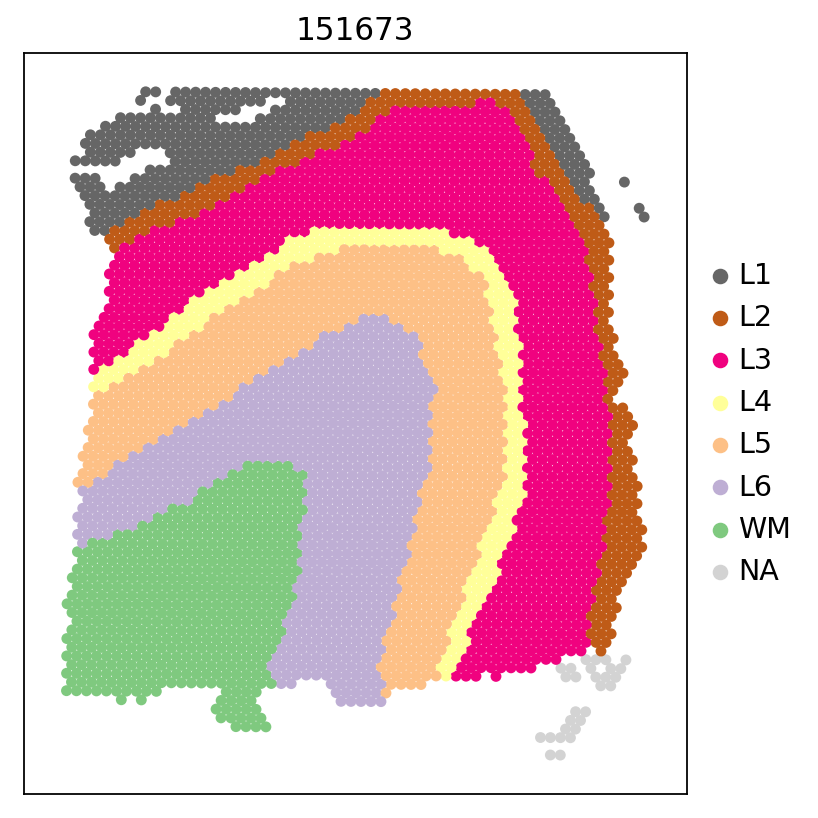

In [44]:
# plot_cell_layers(adata_spatialLIBD_151673.obs)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5),constrained_layout=True)

sc.pl.spatial(
    adata_spatialLIBD_151673,
    img_key=None,
    color="spatialLIBD",
    palette='Accent_r',
    size=1.5,
    title = f'151673',
    # legend_loc = 4,
    spot_size=100,
    show=False,
    ax=ax)

ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')

fig.show()

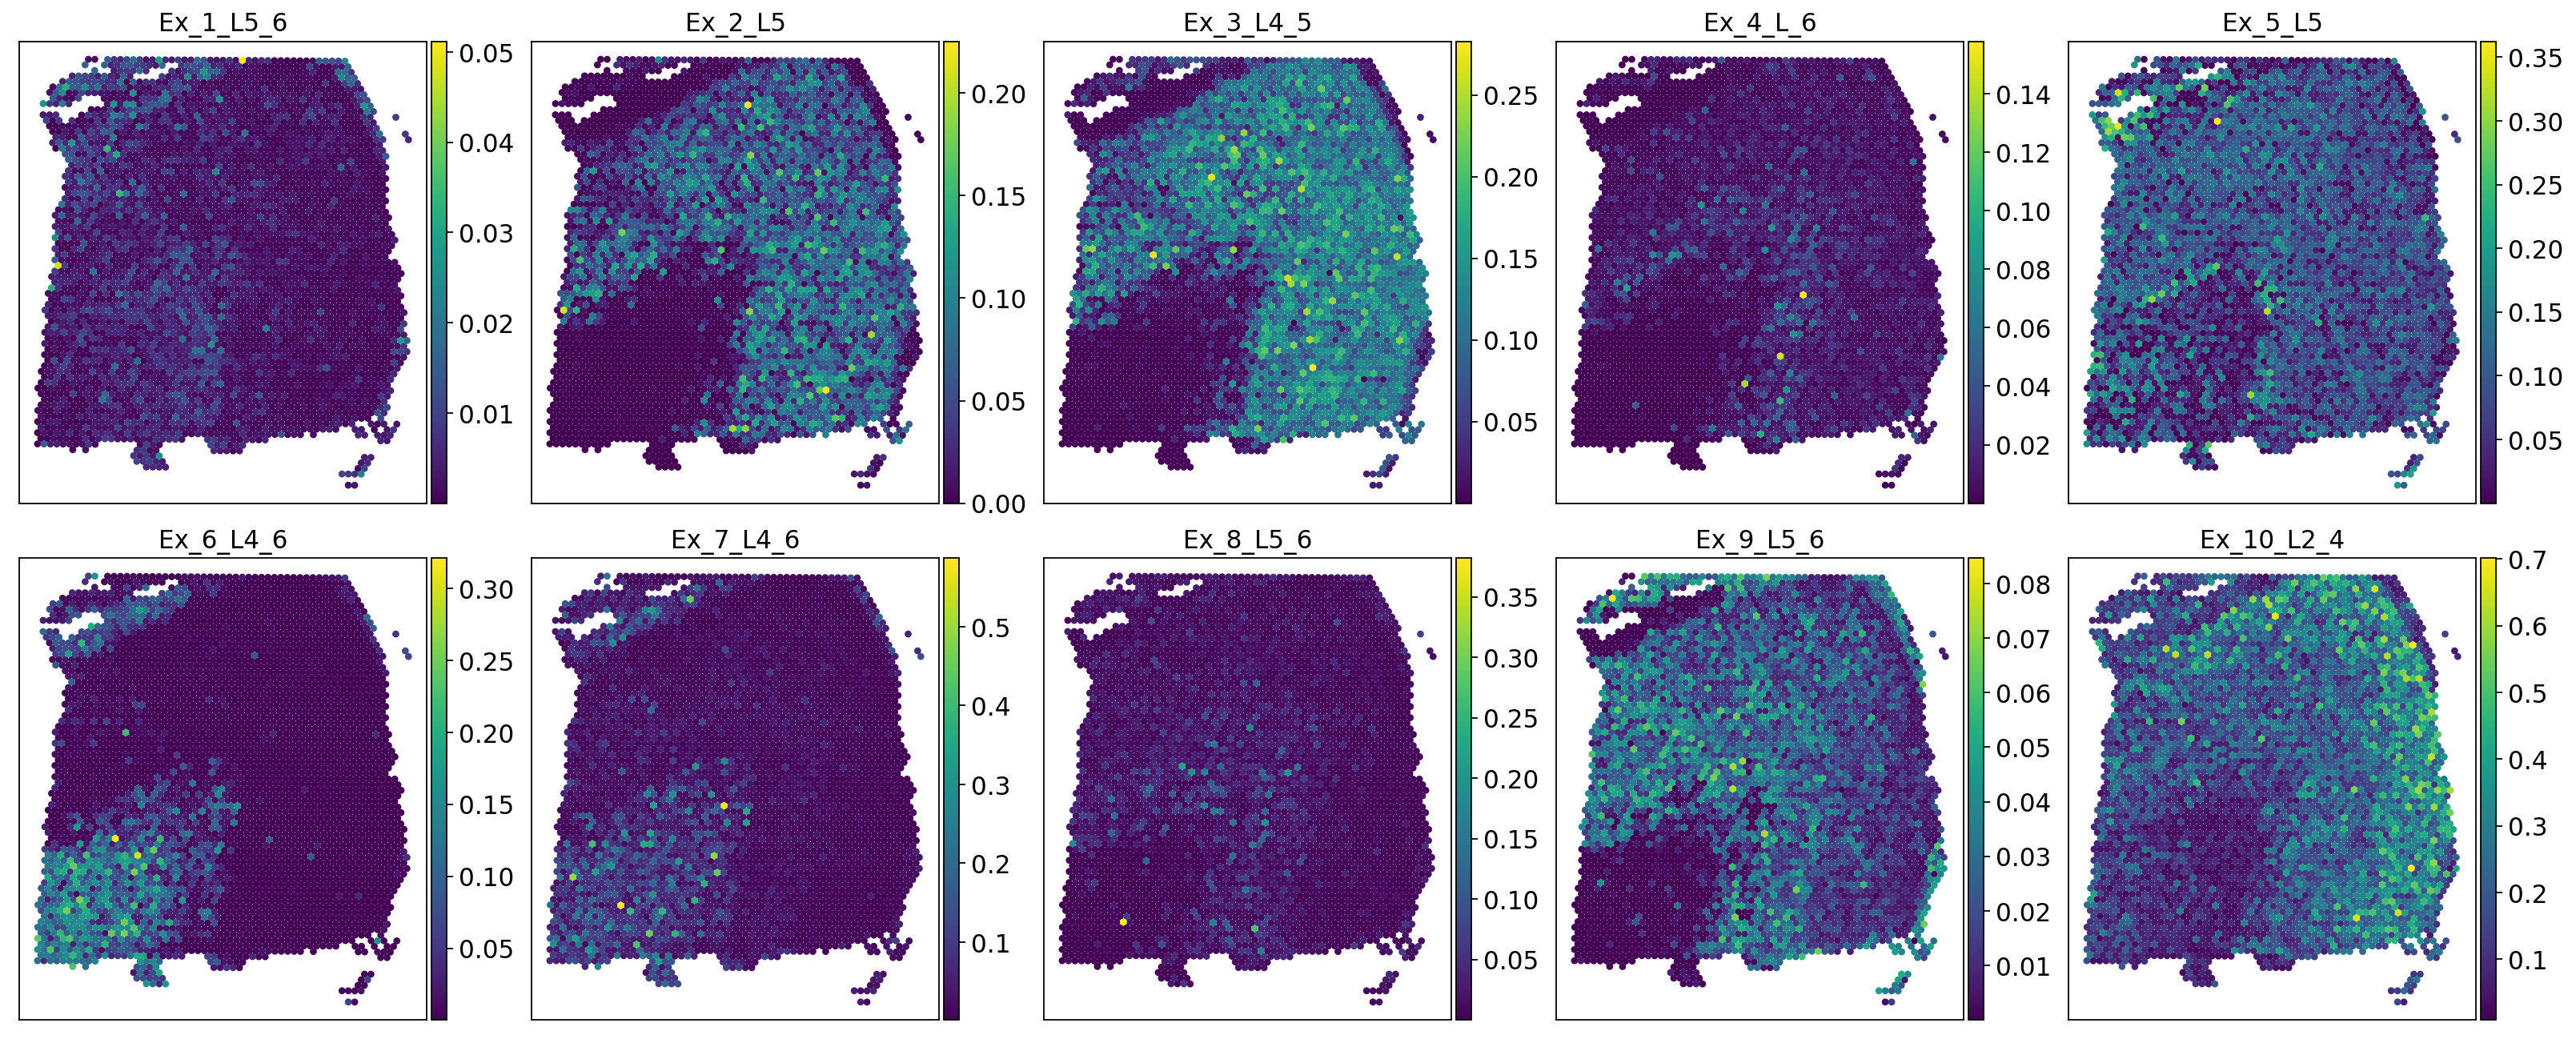

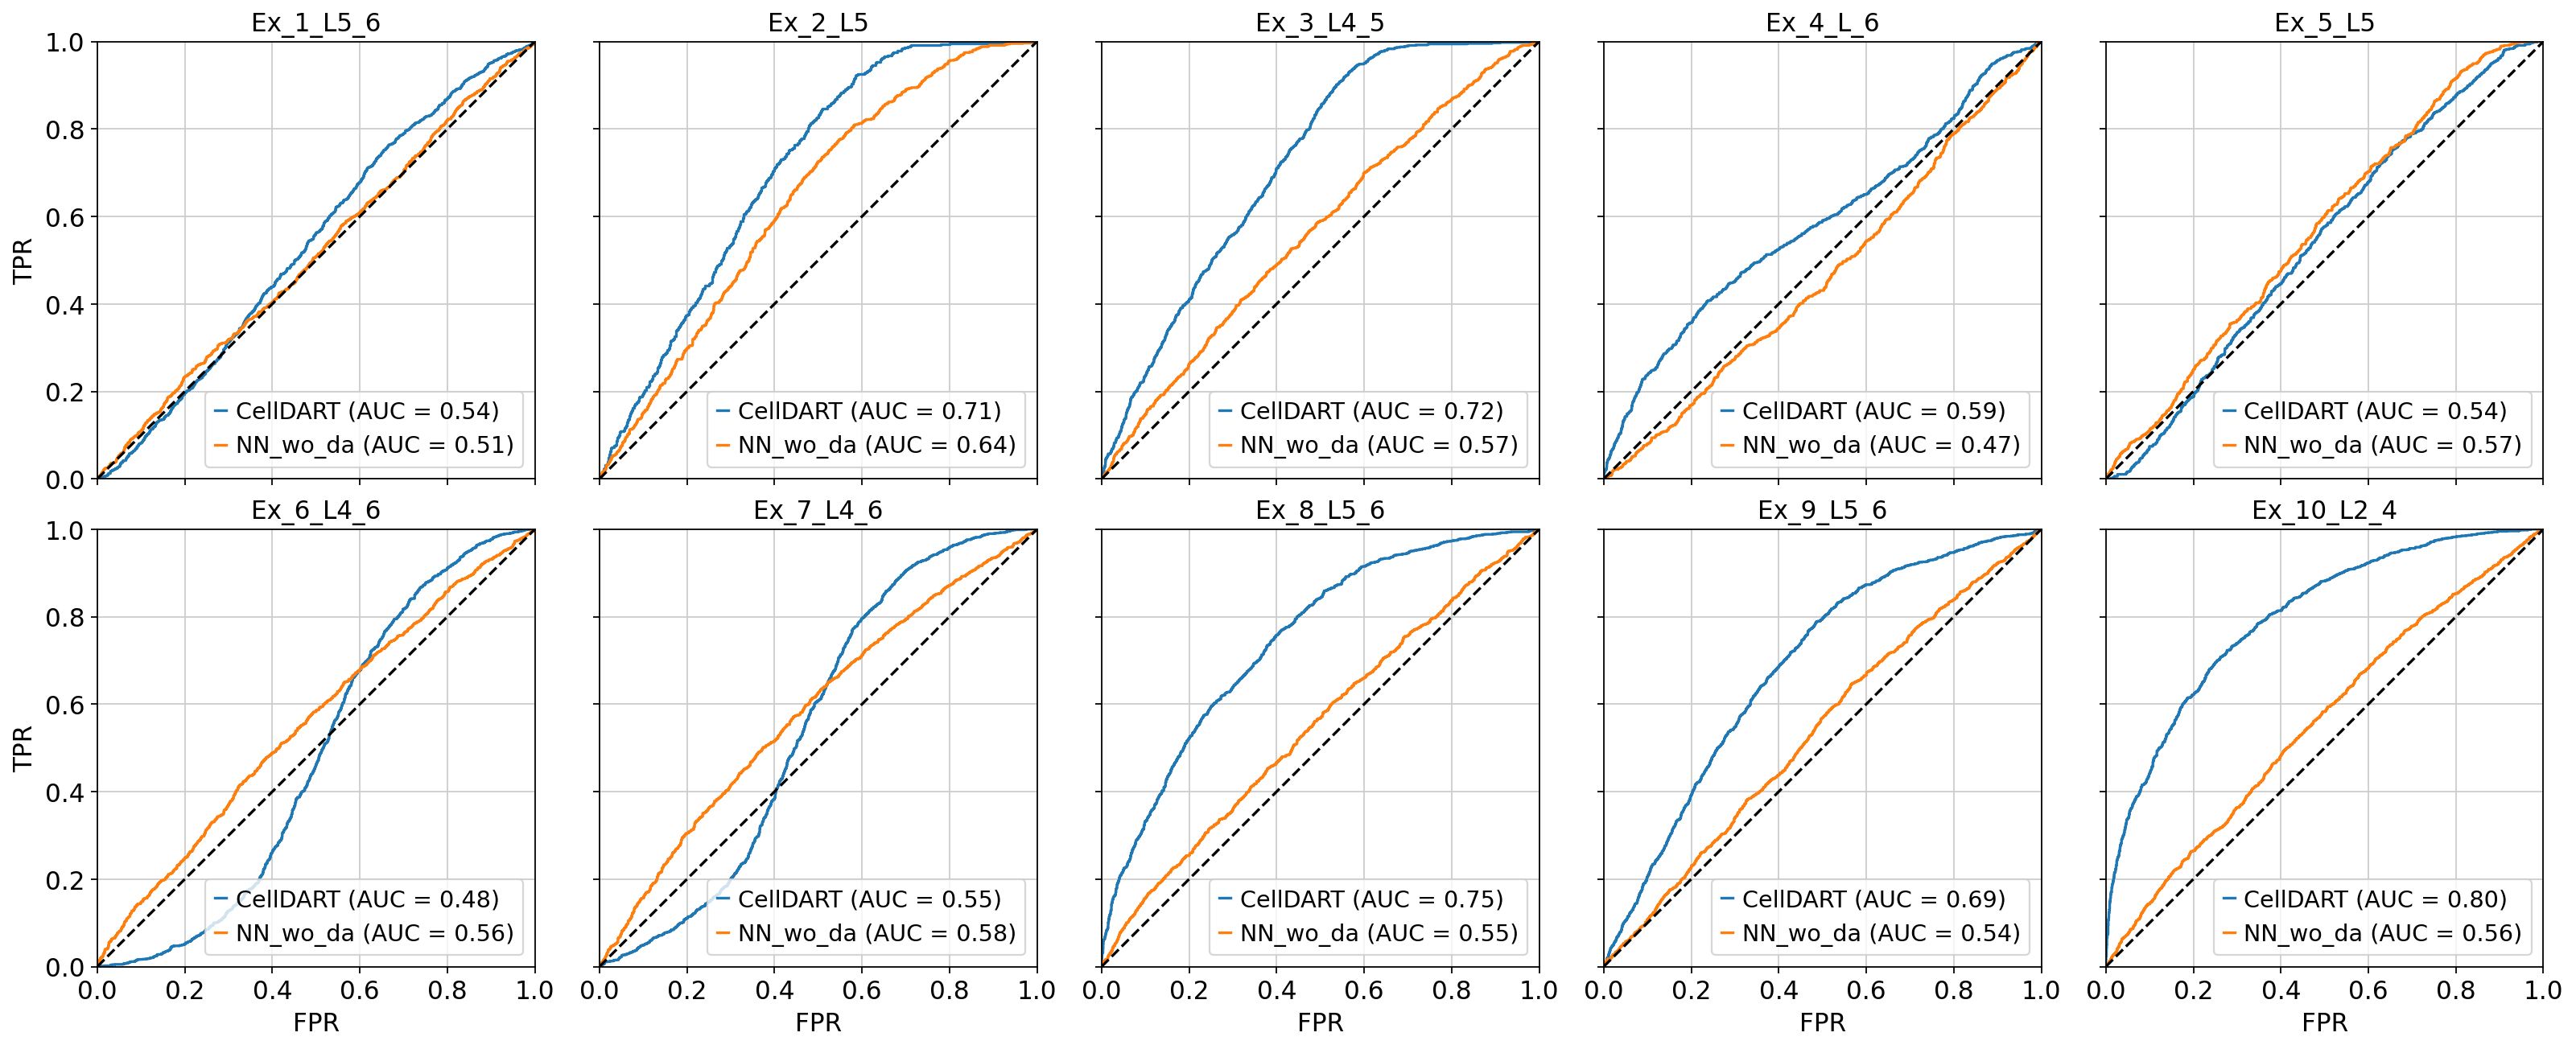

In [45]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

for i, num in enumerate(numlist):
    plot_cellfraction(
        num, adata_spatialLIBD_151673, pred_sp, ax.flat[i]
    )
    ax.flat[i].axis("equal")
    ax.flat[i].set_xlabel("")
    ax.flat[i].set_ylabel("")

fig.show()
# plt.close()

fig, ax = plt.subplots(
    2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
)

for i, num in enumerate(numlist):
    plot_roc(
        num, adata_spatialLIBD_151673, pred_sp, "CellDART", ax.flat[i]
    )
    plot_roc(
        num,
        adata_spatialLIBD_151673,
        pred_sp_noda,
        "NN_wo_da",
        ax.flat[i],
    )
    ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
    ax.flat[i].set_aspect("equal")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    ax.flat[i].set_title(f"{sc_sub_dict[num]}")

    if i >= len(numlist) - 5:
        ax.flat[i].set_xlabel("FPR")
    else:
        ax.flat[i].set_xlabel("")
    if i % 5 == 0:
        ax.flat[i].set_ylabel("TPR")
    else:
        ax.flat[i].set_ylabel("")

fig.show()
# plt.close()


/home/wma/miniconda3/envs/agreda2/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/wma/miniconda3/envs/agreda2/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/wma/miniconda3/envs/agreda2/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error o

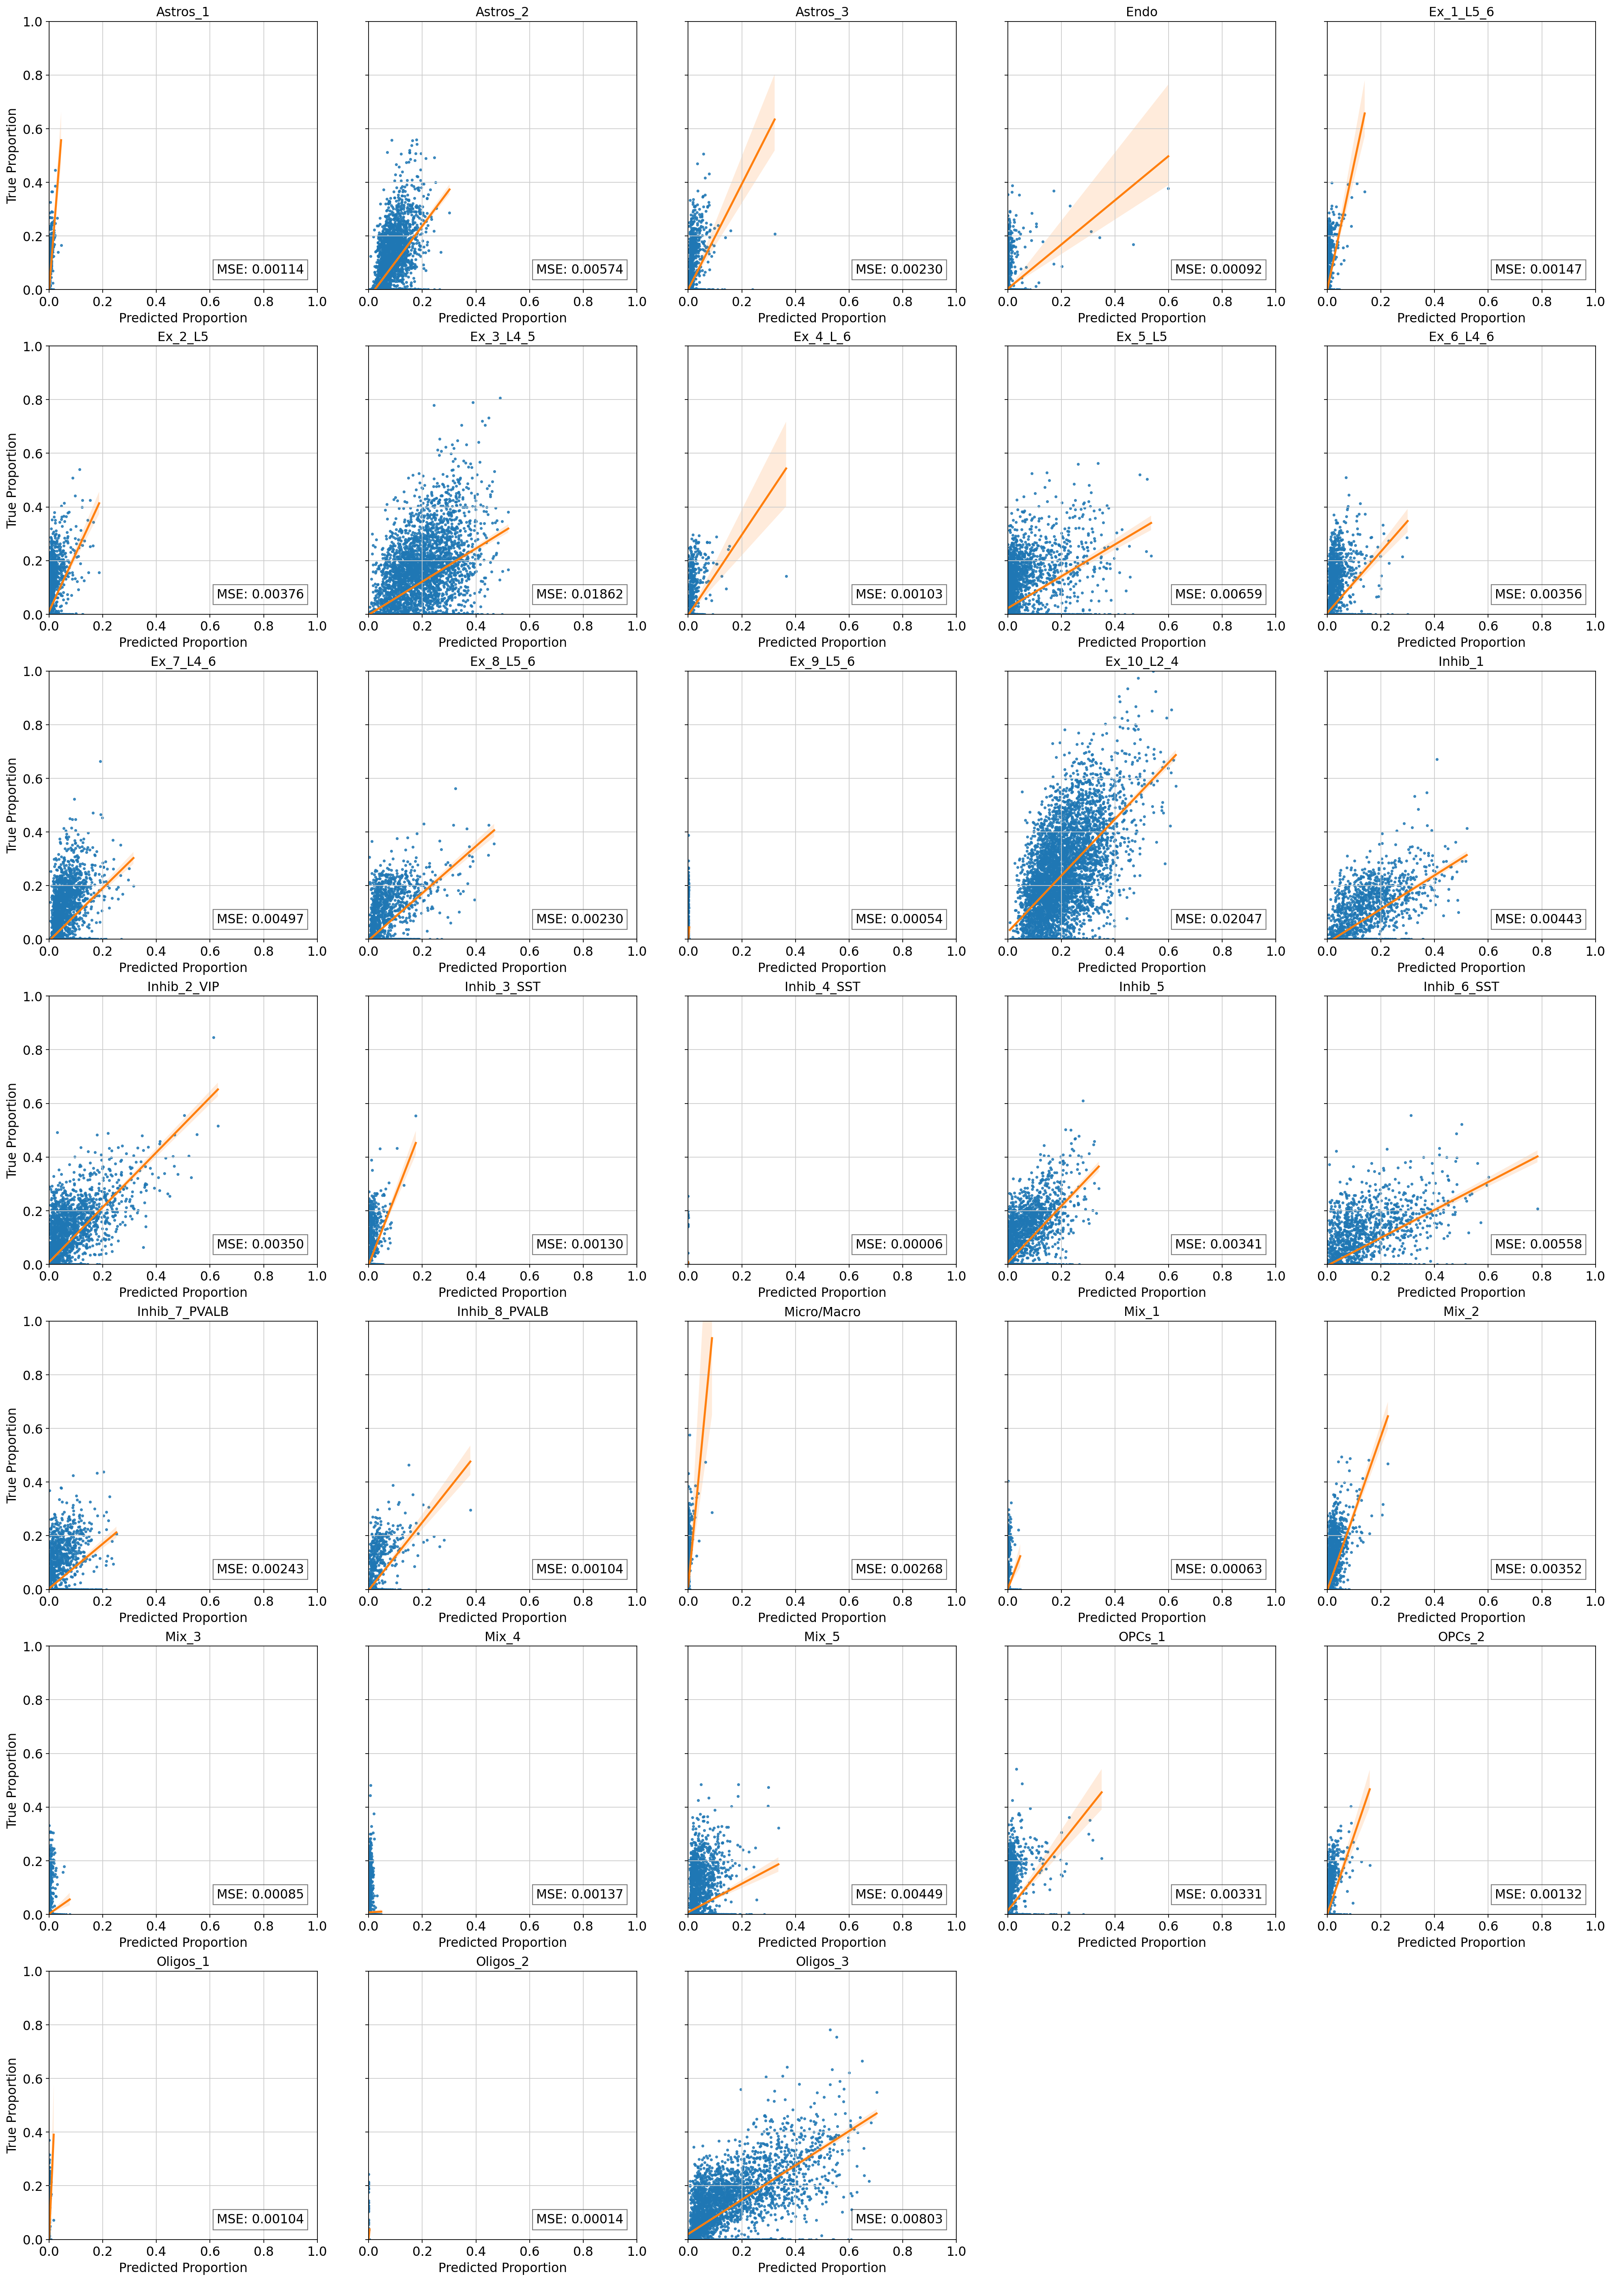

In [46]:
from sklearn.metrics import mean_squared_error

best_checkpoint = torch.load(os.path.join(advtrain_folder, f'final_model.pth'))
model = best_checkpoint['model']
model.to(device)

model.eval()
model.set_encoder('source')

pred_mix = F.softmax(model(torch.Tensor(sc_mix_test_s).to(device)), dim=1).detach().cpu().numpy()

cell_type_nums = sc_sub_dict.keys()
nrows = ceil(len(cell_type_nums) / 5)

line_kws = {'color':'tab:orange'}
scatter_kws = {'s':5}

props = dict(facecolor='w', alpha=0.5)

fig, ax = plt.subplots(nrows, 5, figsize = (25, 5*nrows), constrained_layout=True, sharex=False, sharey=True)
for i, visnum in enumerate(cell_type_nums):    
    sns.regplot(
        pred_mix[:,visnum],
        lab_mix_test[:,visnum], 
        line_kws = line_kws,
        scatter_kws = scatter_kws,
        ax=ax.flat[i]
    ).set_title(sc_sub_dict[visnum])
    ax.flat[i].set_aspect('equal')

    # if i >= len(cell_type_nums) - 5:
    ax.flat[i].set_xlabel('Predicted Proportion')
    # else:
    #     ax.flat[i].set_xlabel('')
    if  i % 5 == 0:
        ax.flat[i].set_ylabel('True Proportion')
    else:
        ax.flat[i].set_ylabel('')
    ax.flat[i].set_xlim([0,1])
    ax.flat[i].set_ylim([0,1])

    textstr = f'MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}'

    # place a text box in upper left in axes coords
    ax.flat[i].text(0.95, 0.05, textstr, transform=ax.flat[i].transAxes,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)

for i in range(len(cell_type_nums), nrows*5):
    ax.flat[i].axis('off')

plt.show()